# DeepTDA

Reference paper: _Ray, Trizio and Parrinello, [JCP](https://pubs.aip.org/aip/jcp/article/158/20/204102/2891484) (2023)_ [[arXiv]](https://arxiv.org/abs/2303.01629).

## Setup

In [1]:
import sys

sys.path.append('/home/domain/geraseva/geraseva_data/mlcolvar')


In [2]:
# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, kstest

import os
from tqdm import tqdm

import MDAnalysis as mda
from MDAnalysis.analysis import distances
from mlcolvar.data import DictDataset

from mlcolvar.cvs import DeepTDA
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)


import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')

/home/domain/data/prog/miniconda3/envs/mlcolvar/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
r0_dict={'HH':1.30,'HN':1.30,'HC':1.30,'HO':1.30,'HS':1.53,
             'NH':1.30,'NN':1.36,'NC':1.53,'NO':1.53,'NS':2.01,
             'CH':1.30,'CN':1.53,'CC':1.72,'CO':1.42,'CS':2.01,
             'OH':1.30,'ON':1.53,'OC':1.42,'OO':1.30,'OS':2.01,
             'SH':1.53,'SN':2.01,'SC':2.01,'SO':1.30,'SS':2.01,}

def coordination(r, r0=1.53, d0=0, n=6, m=12 ):
    c=(1-((r-d0)/r0)**n)/(1-((r-d0)/r0)**m)
    return c


def write_plumed_files(model, pairs, resnames, resid, names, 
                       walls=None, means=None, stds=None, prefix='model', r0s=None):

    model.to_torchscript(f'{prefix}.ptc', method='trace')
    s=f'# ------------- {prefix}.dat -------------\n'
    if isinstance(r0s,type(None)):
        for i, x in enumerate(zip(pairs, resnames, resid,names)):
            s+=(f'd{i}: DISTANCE ATOMS={x[0][0]},{x[0][1]} ')
            s+=(f'# {x[1][0]}{x[2][0]}_{x[3][0]} {x[1][1]}{x[2][1]}_{x[3][1]}\n')  
    else:
        for i, x in enumerate(zip(pairs, resnames, resid,names, r0s)):
            s+=(f'd{i}: COORDINATION GROUPA={x[0][0]} GROUPB={x[0][1]} R_0={round(x[4]/10, 3)} ')
            s+=(f'# {x[1][0]}{x[2][0]}_{x[3][0]} {x[1][1]}{x[2][1]}_{x[3][1]}\n') 
            
    s+=(f'cv: PYTORCH_MODEL FILE={prefix}.ptc ARG={",".join(["d"+str(x) for x in range(len(pairs))])}\n')
    if walls!=None:
        s+=(f'# WALLS: {"; ".join([str(x) for x in walls])}\n')
    if means!=None:
        s+=(f'# MEANS: {"; ".join([str(x) for x in means])}\n')
    if stds!=None:
        s+=(f'# STDS: {"; ".join([str(x) for x in stds])}\n')
    s+=('# --------------------------------------')
    with open(f'mlcolvar/{prefix}.dat','w') as f:
        f.write(s)
    return s

three2one = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'HSD': 'H', 'HSE': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

In [5]:
import copy

def GetPlumedColumns(f):
    with open(f,'r') as dat:
        arr = dat.readline().split()
    return arr[2:]

def LoadNumpy(f,names):
    a = np.loadtxt(f)
    df = pd.DataFrame()
    for i,n in enumerate(names):
        df[n] = a[:,i]
    return copy.deepcopy(df)
    
def CV2Pandas(f):
    names=GetPlumedColumns(f)
    df=LoadNumpy(f,names)
    return df

def Pandas2CV (df,out):
    h = '#! FIELDS ' +  ' '.join(list(df.columns))  
    
    with open(out, 'w') as f:
        f.write(h + '\n')
    df.to_csv( out ,index=False,header= False,sep=' ', float_format='%3.6f',  mode = "a")
    return True

## Data analysis

### Load data

In [6]:

topology='/home/domain/data/ph.kachkin/CASR/7dtw_apo/md.gro' # should be equal for both states
trajectories=['/home/domain/data/ph.kachkin/CASR/7dtw_apo/md.xtc']
u_inact=mda.Universe(topology, trajectories)

trajectories=['/home/domain/data/ph.kachkin/CASR/8szg_apo/md.xtc']
u_activ=mda.Universe(topology, trajectories)

### Filter atoms

Filter necessary atoms, e.g. CA atoms

In [7]:
mask = np.array([False for x in u_inact.atoms.names])
mask = mask + (u_inact.atoms.names=='CA')
mask = mask * (u_inact.atoms.resids<863)

print('Number of atoms:',sum(mask))


Load coordinates and labels for both states

In [8]:
data=[]
labels=[]
for i, u in enumerate([u_inact, u_activ]):
    for j, t in enumerate(tqdm(u.trajectory)):
        #if j%4 >0:
        #    continue
        data.append(u.atoms.positions[mask])
        labels.append(i)
        
data=np.array(data)
labels=np.array(labels)
print(data.shape)


  0%|          | 0/2001 [00:00<?, ?it/s]

100%|██████████| 2001/2001 [00:56<00:00, 35.49it/s]

(4002, 526, 3)


You can also remember atom names

In [166]:
pairs=u_inact.atoms.ids[mask]
names=u_inact.atoms.names[mask]
resnames=u_inact.atoms.resnames[mask]
resid=u_inact.atoms.resids[mask]


Save checkpoint if necessary

In [169]:
save=False
load=False

if save:
    with open('datalabels.npz', 'wb') as f:
        np.savez(f, data, labels, pairs, names, resnames,resid) 
if load:
    with open('datalabels.npz', 'rb') as f:
        npzfile=np.load(f, allow_pickle=True)
    
        data=npzfile['arr_0']
        labels=npzfile['arr_1']
        pairs=npzfile['arr_2']
        names=npzfile['arr_3']
        resnames=npzfile['arr_4']
        resid=npzfile['arr_5']


In [ ]:
# if the number of atoms is not very large,
# you can take all-vs-all distances as model inputs

'''
a1, a2=np.meshgrid(np.arange(0,data.shape[1]),np.arange(0,data.shape[1]))
dist=np.sqrt(((data[:,a1,:]-data[:,a2,:])**2).sum(-1))
'''

# otherwise use filtering and clustering described below

### Filter pairs

Calculate distances between atoms and filter interacting atom pairs

In [151]:
threshold=10 # interaction threshold

grid_size=1 # if memory error, increase

dist=((data[::grid_size,:,None,:]-data[::grid_size,None,:,:])**2).sum(-1)
dist=np.triu(dist, k=4) 

a1, a2=np.nonzero((dist.min(0)<threshold**2)&(dist.min(0)>0))
a1.shape

(2551,)

In [152]:
# recalculate distances

dist=np.sqrt(((data[:,a1,:]-data[:,a2,:])**2).sum(-1))


### Filter by smd

Take distances that vary significantly among states

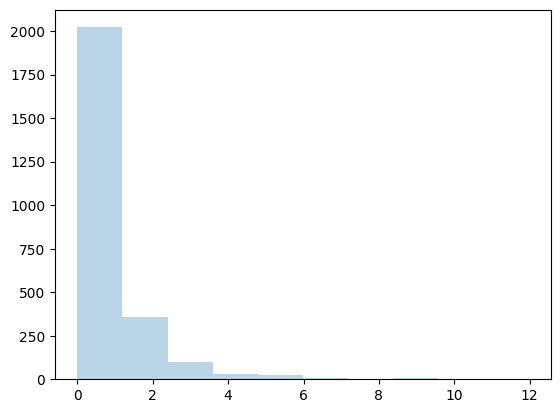

In [153]:
smd=(dist[labels==0,:].mean(0)-dist[labels==1,:].mean(0))/np.sqrt(0.5*(dist[labels==0,:].var(0)+dist[labels==1,:].var(0)))
smd=abs(smd)
smd=np.array(smd)
plt.hist(smd, alpha=0.3)
plt.show()


In [154]:
smd_threshold=6 # set manually

mask=(smd>smd_threshold)
sum(mask)

18

In [155]:
a1=a1[mask]
a2=a2[mask]
dist=dist[mask]
dist.shape

### Clustering

Cluster distances to reduce their number and avoid correlating variables

In [157]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

#from pykeops.numpy import LazyTensor
#import pykeops.config
from sklearn import metrics

In [158]:
# reduce dimensions

pca=PCA(n_components=40)

d=pca.fit_transform(dist.T)
d.shape

(69168, 40)

100%|██████████| 16/16 [32:35<00:00, 122.22s/it]


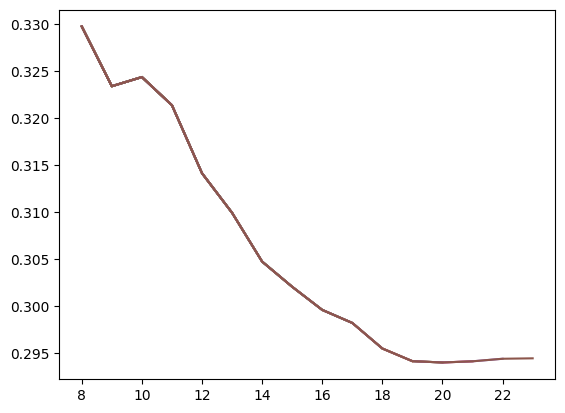

In [ ]:
# use it to detect optimal number of clusters 

scanning_range=range(8,24,1)

from IPython.display import clear_output
sil=[]
for i in tqdm(scanning_range):
    c=KMeans(n_clusters=i).fit(d)
    sil.append(metrics.silhouette_score(d, c.labels_, metric='euclidean'))
    clear_output()
    plt.plot(list(range(8, i+1, 1)),sil)



In [159]:
n_clusters=10

c=KMeans(n_clusters=n_clusters).fit(d)

In [160]:
from sklearn.metrics import pairwise_distances_argmin_min
mask, _ = pairwise_distances_argmin_min(c.cluster_centers_, d)


In [161]:
dist=dist[:,mask]
a1=a1[mask]
a2=a2[mask]
dist.shape

### Visualize selected distances

In [170]:
pairs=list(zip(pairs[a1],pairs[a2]))
names=list(zip(names[a1],names[a2]))
resnames=list(zip(resnames[a1],resnames[a2]))
resid=list(zip(resid[a1],resid[a2]))


Visualize selected distances

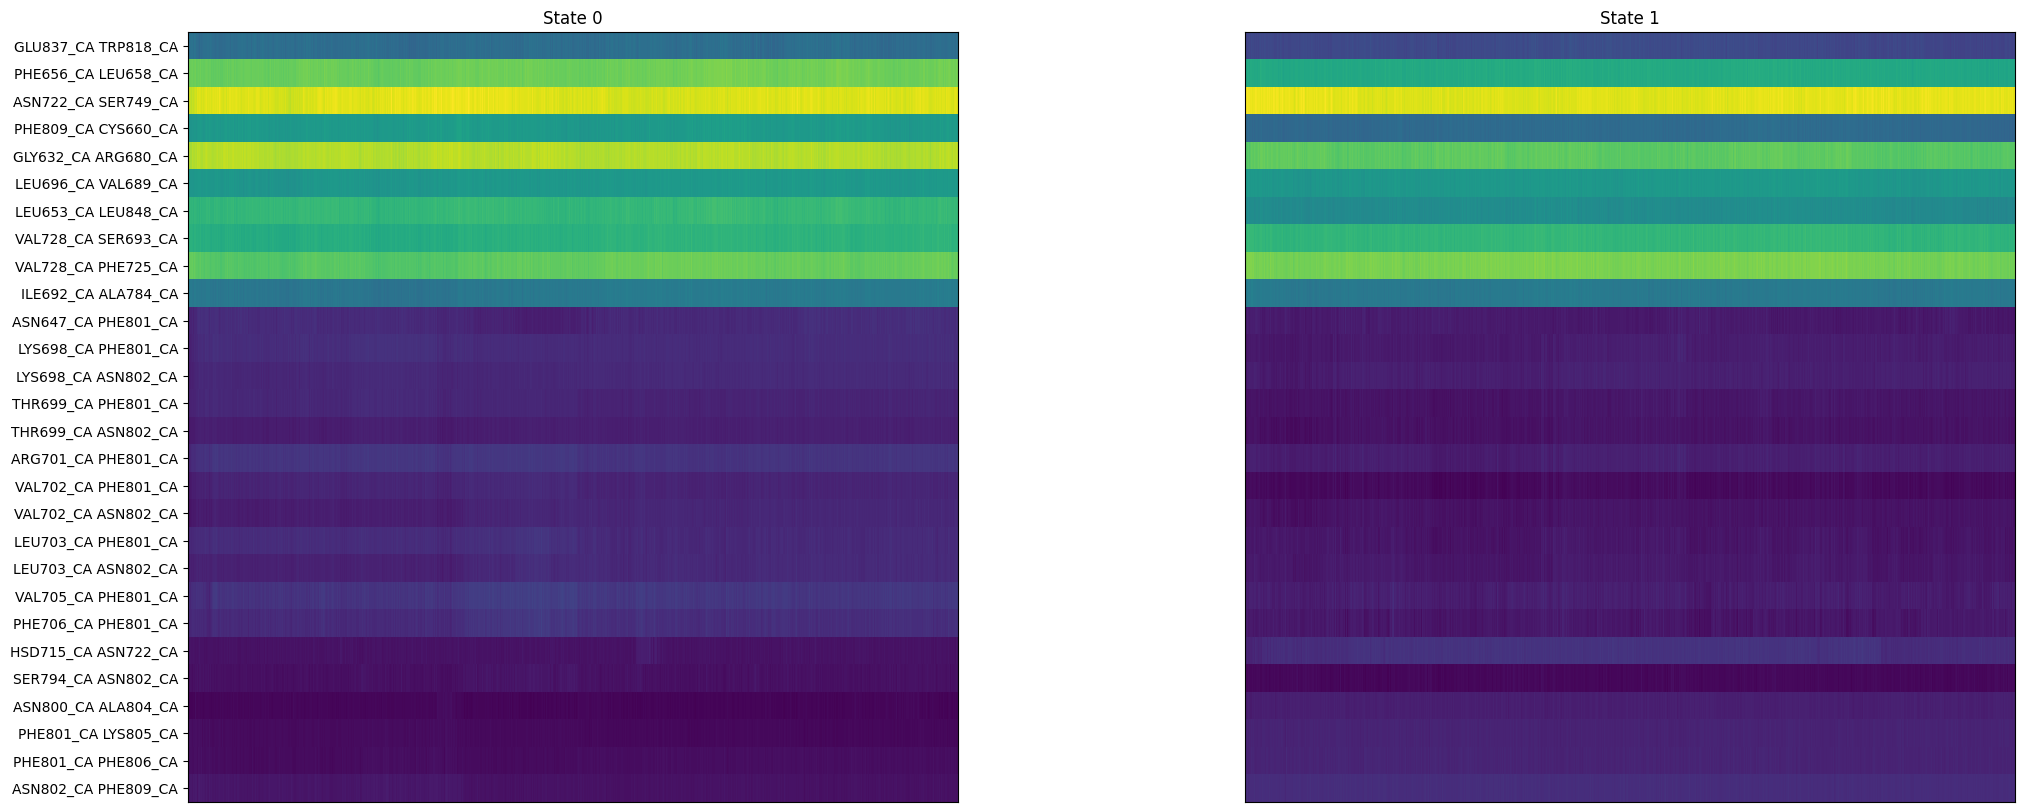

In [174]:
n_states=int(max(labels)+1)

fig, ax=plt.subplots(1,n_states,figsize=(25,10))
for i in range(n_states):
    ax[i].set_title(f'State {i}')
    ax[i].imshow(dist[labels==i].T, aspect=dist[labels==i].shape[0]/dist.shape[1],interpolation='none')
    ax[i].set_xticks([])
    if i:
        ax[i].set_yticks([])
    else:
        ax[i].set_yticks(list(range(0,dist.shape[1])))
        ax[i].set_yticklabels([f'{x[0][0]}{x[1][0]}_{x[2][0]} {x[0][1]}{x[1][1]}_{x[2][1]}' for x in zip(resnames, resid,names)])
plt.show()

## DeepTDA

#### Training

In [175]:
n_bonds=dist.shape[1]

dataset=DictDataset({'data': torch.Tensor(dist)/10, # from angstrom to nanometers
                    'labels': torch.Tensor(labels)
                    })

datamodule = DeepTDAModule(dataset,lengths=[0.8,0.2])

In [176]:
n_cvs = 1
target_centers = [-7,7]
target_sigmas = [0.6, 0.2] # set manually
nn_layers = [n_bonds,n_bonds//2,n_bonds//4,1] # set manually if possible
n_states=2

#model = DeepTDA(n_states=n_states, n_cvs=1,
#                target_centers=target_centers, target_sigmas=target_sigmas, 
#                layers=nn_layers, options={'nn':{'dropout': [0.8,0.2,0]}})
#n_epochs=500

model = DeepTDA(n_states=n_states, n_cvs=1,
                target_centers=target_centers, target_sigmas=target_sigmas, 
                layers=nn_layers) #, options={'nn':{'batchnorm': True}})
n_epochs=300

In [177]:
# define callbacks
metrics = MetricsCallback()

# define trainer
# for better results we can also increase the number of epochs or use a early_stopping
trainer = lightning.Trainer(callbacks=[metrics],
                     max_epochs=n_epochs, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4500') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0     

Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s, v_num=1]          

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s, v_num=1]


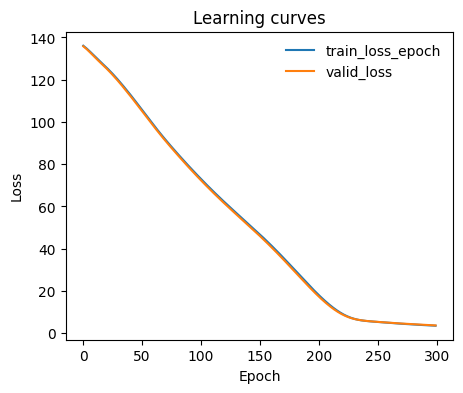

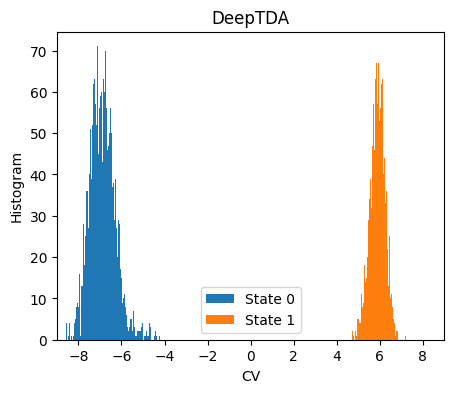

In [179]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  yscale='linear')

fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

model.eval() 
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}')

ax.set_xlabel(f'CV')
ax.set_xlim(-9,9)
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()

In [180]:
stds=[np.std(s[Y==0]),np.std(s[Y==1])]
means=[np.mean(s[Y==0]),np.mean(s[Y==1])]

means,stds

([-6.881275, 5.8904862], [0.6047221, 0.35159326])

In [181]:
walls=[means[0]-3*stds[0],means[1]+3*stds[1]]
walls=[np.percentile(s[Y==0],5),np.percentile(s[Y==1],95)]

# walls=[-9, 7] # set manually

walls

[-9, 7]

This will generate dat file with collective variable description and ptc file with model

In [183]:
prefix='tda_distances'
    
print(write_plumed_files(model, pairs, resnames, resid, names, 
                         walls=walls, means=means, stds=stds, prefix=prefix, 
                         r0s=None)) 

# ------------- tda_distances_upd.dat -------------
d0: DISTANCE ATOMS=3895,8190 # GLU837_CA TRP818_CA
d1: DISTANCE ATOMS=932,5554 # PHE656_CA LEU658_CA
d2: DISTANCE ATOMS=2019,7068 # ASN722_CA SER749_CA
d3: DISTANCE ATOMS=3438,5592 # PHE809_CA CYS660_CA
d4: DISTANCE ATOMS=520,5901 # GLY632_CA ARG680_CA
d5: DISTANCE ATOMS=1558,6043 # LEU696_CA VAL689_CA
d6: DISTANCE ATOMS=875,8642 # LEU653_CA LEU848_CA
d7: DISTANCE ATOMS=2127,6108 # VAL728_CA SER693_CA
d8: DISTANCE ATOMS=2127,6660 # VAL728_CA PHE725_CA
d9: DISTANCE ATOMS=1498,7614 # ILE692_CA ALA784_CA
d10: DISTANCE ATOMS=771,3304 # ASN647_CA PHE801_CA
d11: DISTANCE ATOMS=1593,3304 # LYS698_CA PHE801_CA
d12: DISTANCE ATOMS=1593,3324 # LYS698_CA ASN802_CA
d13: DISTANCE ATOMS=1615,3304 # THR699_CA PHE801_CA
d14: DISTANCE ATOMS=1615,3324 # THR699_CA ASN802_CA
d15: DISTANCE ATOMS=1643,3304 # ARG701_CA PHE801_CA
d16: DISTANCE ATOMS=1667,3304 # VAL702_CA PHE801_CA
d17: DISTANCE ATOMS=1667,3324 # VAL702_CA ASN802_CA
d18: DISTANCE ATOMS=1683,3